In [2]:
from business_models import greenplum

In [28]:
from h3 import h3

import pandas as pd
from shapely.geometry import Point,Polygon
from shapely.geometry import shape, GeometryCollection
import folium

import numpy as np
import geopandas as gpd

import time

import seaborn as sn

from sklearn.cluster import DBSCAN, KMeans

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Обучение

In [10]:
dataset = greenplum("""Select *
from analyst.iat_moscow_sample_fin_0205""")

In [13]:
dataset=dataset[~dataset['external_id'].isin(['207723','91420','91452','91460','74051'])]

In [14]:
train = dataset[dataset.month_order<'2021-05-01']
test = dataset[dataset.month_order=='2021-05-01']

In [15]:
test.groupby('external_id')['count_orders'].sum()

external_id
101892    10254.0
103127     8022.0
103131    11959.0
103143     7614.0
103147    11796.0
           ...   
94832     16750.0
94848      5813.0
94856     14103.0
95104      9003.0
95108      7194.0
Name: count_orders, Length: 213, dtype: float64

In [269]:
X_train_tr, X_train_test,y_train_tr, y_train_test, X_valid,y_valid = get_train_test_valid(dataset , corr_tab_up.index)

In [47]:
I  #  исходная регрессия на 3 выборках
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
sc = MinMaxScaler()


reg = RandomForestRegressor()
reg.fit(X_train_tr, y_train_tr)

reg.get_params()

# ['C2_res',
#                 'Кафе_6mbike',
#                 'Бизнес-центр_6mbike',
#                 'Быстрое питание_hex',
#                 'Бизнес-центр_hex',
# 'cte_mean',
# 'dist2lavki',
# 'dist2samokat',
# 'lavka_exist_month',
# '%_4554',
# 'C1_res',
# 'ttl_pop',
# 'cte_std',
# '%_2544',
# '%_C12_res',
# '%_C12_work',
#                 '%'
# 'dist_lavka_by_samokat']


# feature_list = ['lavka_exist_month',
#        'ttl_pop_res', 'A_res', 'B1_res', 'B2_res', 'C1_res', 'C2_res',
#        '0_17_res', '18_24_res', '25_34_res', '35_44_res', '45_54_res',
#        '55_99_res', 'f_res', 'm_res', '%_female_res', '%_C12_res',
#        '%_2534', '%_3544', '%_2544', '%_4554', 'ttl_pop_work', 
#        'C1_work', 'C2_work',  '25_34_work', 'dist_lavka_by_samokat', 'f_work', 'ttl_pop',
#        'cte_mean', 'cte_std', 'dist2samokat', 'dist2lavki']




KeyboardInterrupt: 

In [23]:
from sklearn.metrics import r2_score, mean_squared_error

In [43]:
r2_score( y_test, reg.predict(X_test))

0.842665407003194

In [44]:
r2_score( y_train_test, reg.predict(X_train_test))

0.828131409695354

In [ ]:
# проверка факторов на корелляцию

In [77]:
corr_tab = abs(pd.concat([X_train_tr,y_train_tr], axis=1).corr()).sort_values('count_orders', ascending=False)[
    abs(pd.concat([X_train_tr,y_train_tr], axis=1).corr()).sort_values('count_orders', ascending=False).index
]

In [79]:
corr_tab_up = corr_tab.copy()
c=0
i=0
while i<len(corr_tab_up)-1:
    for i in range(c, len(corr_tab_up)):
        max_cor = corr_tab_up.iloc[i,:i].max()
        print(i,corr_tab_up.index[i],max_cor)
        if max_cor>0.8:
            corr_tab_up.drop(corr_tab_up.index[i], axis=0, inplace=True)
            corr_tab_up.drop(corr_tab_up.columns[i], axis=1, inplace=True) 
            c=i
            break 

feature_list = corr_tab_up.index#[ i for i in train.columns.tolist()[3:] if i!='count_orders']



0 C2_res nan
1 C1_res 0.7872060314436939
2 25_34_res 0.9586321920353703
2 ttl_pop 0.8014981144031276
2 f_res 0.9699873614138435
2 ttl_pop_res 0.9701814765897062
2 m_res 0.9652943219049076
2 55_99_res 0.9008137213108767
2 45_54_res 0.9359514036057586
2 35_44_res 0.956198639552007
2 18_24_res 0.8858710019908426
2 %_C12_res 0.5974563912256589
3 B2_res 0.8531058339202349
3 0_17_res 0.8227953999683691
3 %_C12_work 0.7421846992291649
4 %_female_res 0.7632686989448665
5 dist2lavki 0.3584545266484868
6 %_female_work 0.7707446274150478
7 A_res 0.6480499595582584
8 Магазин алкогольных напитков_6mbike 0.34290090858405153
9 Магазин продуктов_6mbike 0.8519612337985699
9 55_99_work 0.4567581798894624
10 B2_work 0.9136017024605964
10 flg_lavka_15m 0.7334928510217911
11 45_54_work 0.9486153256425359
11 B1_res 0.7751096281566912
12 f_work 0.9120586515676498
12 %_2544 0.7868191028960989
13 Супермаркет_6mbike 0.6265837121486246
14 ttl_pop_work 0.908021895420196
14 %_2534 0.9064485433054851
14 0_17_work 0

In [78]:
corr_tab.drop('count_orders', axis=1, inplace=True)
corr_tab.drop('count_orders', axis=0, inplace=True)

In [268]:
def get_train_test_valid(dataset , feature_list):
    
    train = dataset[dataset.month_order<'2021-05-01']
    test = dataset[dataset.month_order=='2021-05-01']
    
    X_train_tr, X_train_test,y_train_tr, y_train_test = train_test_split(train[feature_list],train.count_orders, test_size=0.3 )

    # y_train_log = np.log(train.count_orders)

    X_test = test[feature_list]
    y_test = test.count_orders
    # y_test_log = np.log(test.count_orders)
    return X_train_tr, X_train_test,y_train_tr, y_train_test, test[feature_list], test.count_orders

def get_best_rf_model(X_train_tr,y_train_tr, cv):
    
    max_feature= min(15,X_train_tr.shape[1] )

    # Create the parameter grid based on the results of random search 
    param_grid = {
        'bootstrap': [True],
        'max_depth': np.arange(5,12,1),
        'max_features': [max_feature] ,
        'min_samples_leaf': [20],
        'n_estimators': np.arange(10,30,3)
    }
    # Create a based model
    rf = RandomForestRegressor(random_state=42)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                              cv = cv, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error' )

    # Fit the grid search to the data
    grid_search.fit(X_train_tr, y_train_tr)
    print(grid_search.best_params_)

    best_grid = grid_search.best_estimator_

    return best_grid

In [270]:
best_grid = get_best_rf_model(X_train_tr,y_train_tr, cv=3)

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'bootstrap': True, 'max_depth': 10, 'max_features': 15, 'min_samples_leaf': 20, 'n_estimators': 16}


In [ ]:
# постепенно убираем мало значимые фичи

0.7774526045944586 0.748836317739032 0.7125536956861638


<AxesSubplot:ylabel='0'>

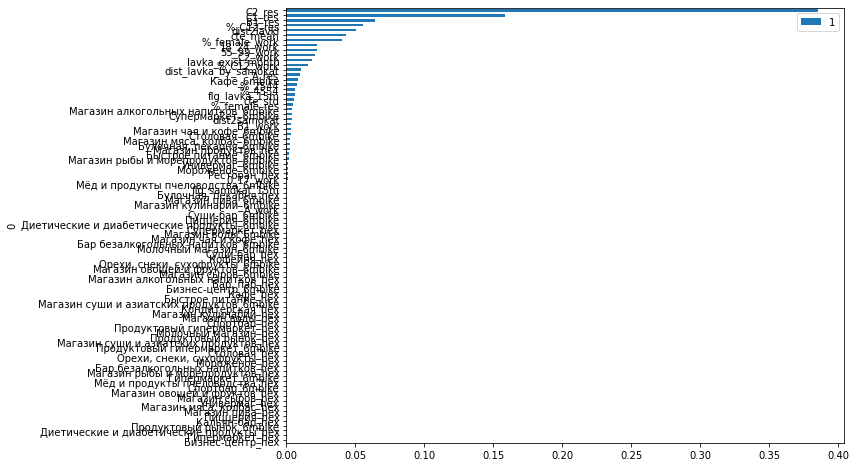

In [266]:
 print(r2_score(y_train_tr,best_grid.predict(X_train_tr)),
         r2_score(y_train_test,best_grid.predict(X_train_test)),
         r2_score(y_valid,best_grid.predict(X_valid)), 
         )

ft_imp = pd.DataFrame((zip(X_train_tr.columns,best_grid.feature_importances_)))\
            .sort_values(1,ascending=True)\
            .set_index(0)

ft_imp.plot(kind='barh', figsize=(10,8))

In [267]:
ft_imp.sort_values(1,ascending=False).index[:20]

Index(['C2_res', 'C1_res', 'B1_res', '%_C12_res', 'dist2lavki', 'cte_mean',
       '%_female_work', '18_24_work', '55_99_work', 'C2_work',
       'lavka_exist_month', '%_C12_work', 'dist_lavka_by_samokat', 'A_res',
       'Кафе_6mbike', '%_2544', '%_4554', 'flg_lavka_15m', 'cte_std',
       '%_female_res'],
      dtype='object', name=0)

In [271]:
ft_imp.sort_values(1,ascending=False).index[:20]

Index(['C2_res', 'C1_res', 'B1_res', '%_C12_res', 'dist2lavki', 'cte_mean',
       '%_female_work', '18_24_work', '55_99_work', 'C2_work',
       'lavka_exist_month', '%_C12_work', 'dist_lavka_by_samokat', 'A_res',
       'Кафе_6mbike', '%_2544', '%_4554', 'flg_lavka_15m', 'cte_std',
       '%_female_res'],
      dtype='object', name=0)

In [277]:
features20 = ft_imp.sort_values(1,ascending=False).index[:25]

In [278]:
features20

Index(['C2_res', 'C1_res', '%_C12_res', 'B1_res', 'dist2lavki', '55_99_work',
       'cte_mean', 'A_res', '18_24_work', 'lavka_exist_month', '%_female_res',
       'Кафе_6mbike', 'dist_lavka_by_samokat', '%_C12_work', 'C2_work',
       'Магазин алкогольных напитков_6mbike', 'Булочная, пекарня_6mbike',
       'Супермаркет_6mbike', '%_4554', '%_2544', 'dist2samokat', 'cte_std',
       '%_female_work', 'flg_lavka_15m', 'Пиццерия_6mbike'],
      dtype='object', name=0)

In [279]:
X_train_tr, X_train_test,y_train_tr, y_train_test, X_valid,y_valid = get_train_test_valid(dataset , features20)

best_grid = get_best_rf_model(X_train_tr,y_train_tr, cv=3)

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'bootstrap': True, 'max_depth': 10, 'max_features': 15, 'min_samples_leaf': 20, 'n_estimators': 22}


0.8090463231773266 0.780938244017811 0.7470018697929084


<AxesSubplot:ylabel='0'>

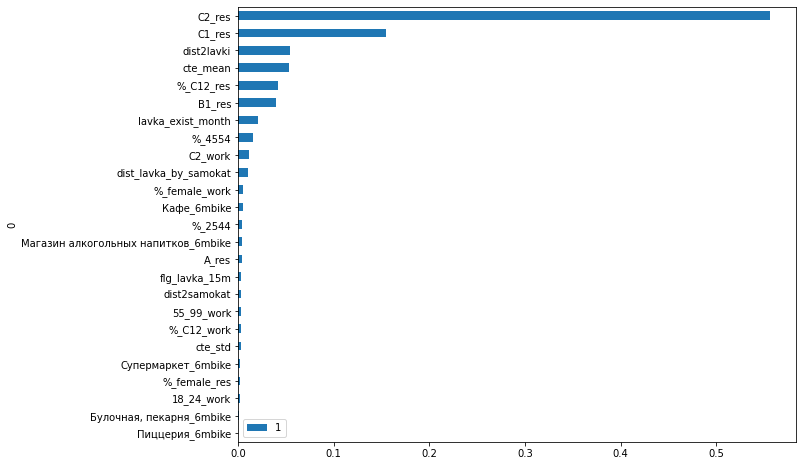

In [283]:
print(r2_score(y_train_tr,best_grid.predict(X_train_tr)),
         r2_score(y_train_test,best_grid.predict(X_train_test)),
         r2_score(y_valid,best_grid.predict(X_valid)), 
         )

ft_imp = pd.DataFrame((zip(X_train_tr.columns,best_grid.feature_importances_)))\
            .sort_values(1,ascending=True)\
            .set_index(0)

ft_imp.plot(kind='barh', figsize=(10,8))

In [282]:
ft_imp

,1
0,
Пиццерия_6mbike,0.000298
"Булочная, пекарня_6mbike",0.001272
18_24_work,0.001949
%_female_res,0.002158
Супермаркет_6mbike,0.002294
cte_std,0.002458
%_C12_work,0.002602
55_99_work,0.002966
dist2samokat,0.003094


In [284]:
features_core = \
['cte_std',
'%_C12_res',
'C2_work',
'%_2544',
'Кафе_6mbike',
 '%_female_work',
'dist_lavka_by_samokat',
'Магазин алкогольных напитков_6mbike',
'lavka_exist_month',
'%_4554',
'C1_res',
'cte_mean',
'dist2lavki',
'C2_res']
#ft_imp.index[-13:]
best_grid = get_best_rf_model(X_train_tr[features_core],y_train_tr, cv=3)

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'bootstrap': True, 'max_depth': 11, 'max_features': 14, 'min_samples_leaf': 20, 'n_estimators': 28}


0.8107408830539212 0.7797397563107766 0.7464284685548694


<AxesSubplot:ylabel='0'>

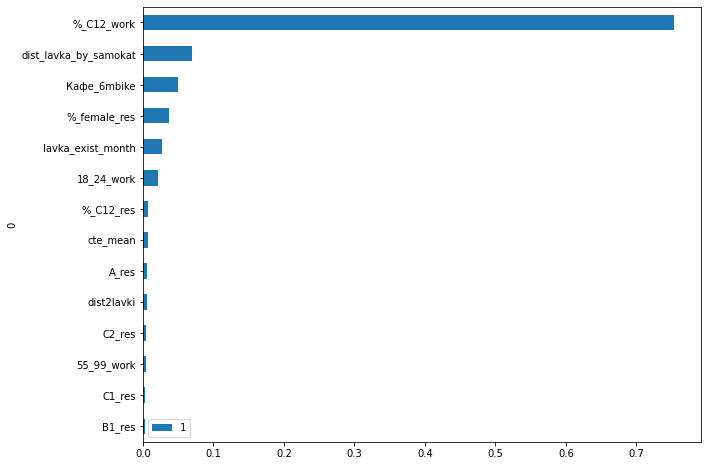

In [286]:
print(r2_score(y_train_tr,best_grid.predict(X_train_tr[features_core])),
         r2_score(y_train_test,best_grid.predict(X_train_test[features_core])),
         r2_score(y_valid,best_grid.predict(X_valid[features_core])), 
         )

ft_imp = pd.DataFrame((zip(X_train_tr.columns,best_grid.feature_importances_)))\
            .sort_values(1,ascending=True)\
            .set_index(0)

ft_imp.plot(kind='barh', figsize=(10,8))

In [287]:
ft_imp

,1
0,
B1_res,0.002348
C1_res,0.002608
55_99_work,0.003691
C2_res,0.005022
dist2lavki,0.006142
A_res,0.006175
cte_mean,0.006804
%_C12_res,0.007722
18_24_work,0.021250


In [291]:
X_valid.shape

(13550, 25)

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


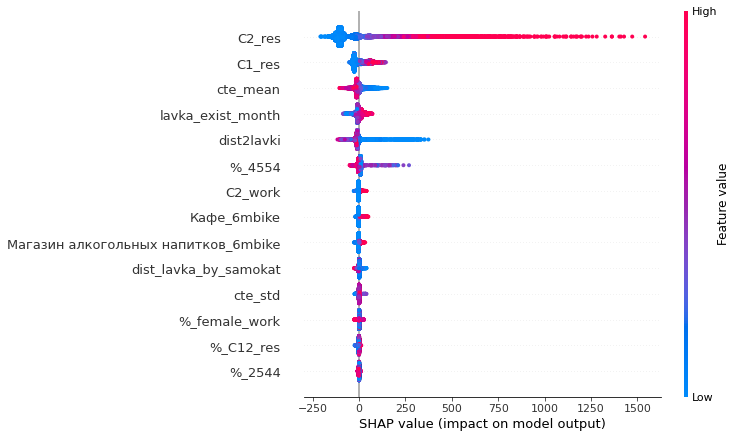

In [288]:

shap_test = shap.TreeExplainer(best_grid).shap_values(X_valid[features_core])
shap.summary_plot(shap_test, X_valid[features_core],
                      max_display=25, auto_size_plot=True)

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


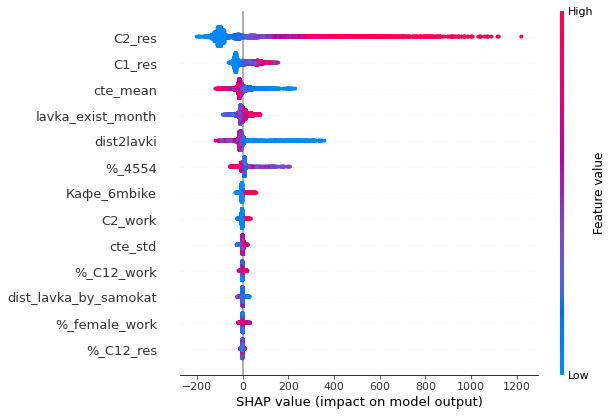

In [141]:
import shap

shap_test = shap.TreeExplainer(best_grid).shap_values(X_valid)
shap.summary_plot(shap_test, X_valid,
                      max_display=25, auto_size_plot=True)

In [292]:
test['predict_orders'] = best_grid.predict(X_valid[features_core])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [126]:
test.groupby('external_id')['predict_orders'].sum()

external_id
101892     8043.323475
103127     6791.875178
103131    12820.228477
103143    13630.813000
103147    17284.886101
              ...     
94832     16060.836535
94848      6331.826511
94856     11807.245863
95104      9078.748840
95108      7468.918081
Name: predict_orders, Length: 213, dtype: float64

# Оценка на тесте

In [294]:
res = best_grid.predict(X_test[features_core])
print(reg.score(X_test[features_core], y_test))

IndexError: list index out of range

Text(0, 0.5, 'predict')

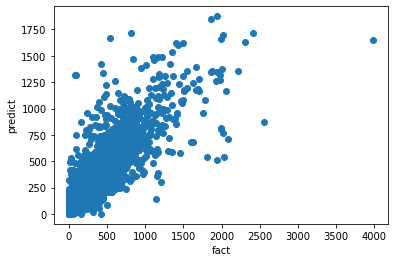

In [295]:
plt.scatter(y_train_test, best_grid.predict(X_train_test[features_core]))
plt.xlabel('fact')
plt.ylabel('predict')

Text(0, 0.5, 'predict')

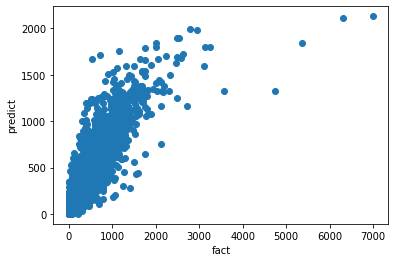

In [296]:
plt.scatter(y_train_tr, best_grid.predict(X_train_tr[features_core]))
plt.xlabel('fact')
plt.ylabel('predict')

In [298]:
pd.DataFrame([features_core, reg.feature_importances_]).T

,0,1
0,cte_std,0.0
1,%_C12_res,0.0
2,C2_work,0.0
3,%_2544,0.0
4,Кафе_6mbike,0.0
5,%_female_work,0.0
6,dist_lavka_by_samokat,0.0
7,Магазин алкогольных напитков_6mbike,0.0
8,lavka_exist_month,0.0
9,%_4554,0.0


# Чуть более детальное сравнение fact и predict на тесте

In [345]:
test['predict'] = res

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Это по гексагонам

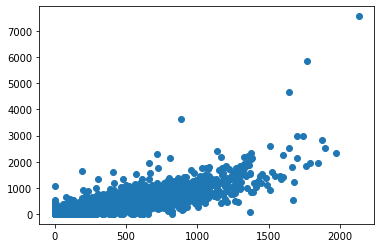

In [299]:
plt.scatter(test['predict_orders'], test['count_orders'])

In [300]:
by_place = test.groupby('external_id').agg({'predict_orders':'sum', 'count_orders':'sum', 'lavka_exist_month':'mean'})

#### это по лавкам

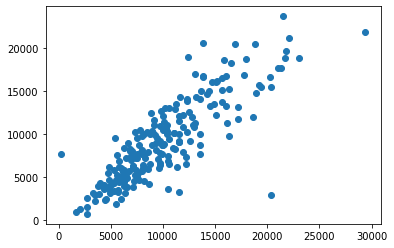

In [301]:
plt.scatter(by_place['predict_orders'], by_place['count_orders'])

In [302]:
by_place['diff'] = (by_place['predict_orders'] - by_place['count_orders'])

In [303]:
by_place['ratio'] = abs(by_place['predict_orders'] - by_place['count_orders'])/by_place['count_orders']
by_place['signed_ratio'] = (by_place['predict_orders'] - by_place['count_orders'])/by_place['count_orders']
by_place['diff'] = (by_place['predict_orders'] - by_place['count_orders'])/31
by_place['count_orders_per_day'] = (by_place['count_orders'])/31

(0.0, 1.0)

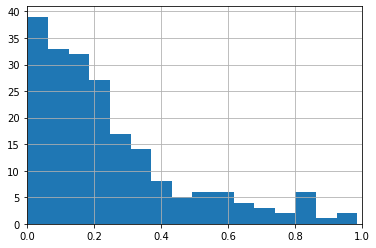

In [304]:
by_place[by_place.ratio<np.inf]['ratio'].hist(bins=100)
plt.xlim(0,1)

In [305]:
by_place['diff'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9])

count    213.000000
mean      29.601979
std       87.231314
min     -239.059245
10%      -67.135818
20%      -34.206677
30%      -12.699256
40%        8.778428
50%       27.921426
60%       41.600320
70%       68.198614
80%       85.810879
90%      118.896124
max      564.136618
Name: diff, dtype: float64

In [306]:
by_place['ratio'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9])

count    213.000000
mean       0.328766
std        0.555501
min        0.001892
10%        0.039658
20%        0.069649
30%        0.103770
40%        0.150794
50%        0.188930
60%        0.234459
70%        0.313584
80%        0.436275
90%        0.678997
max        6.155662
Name: ratio, dtype: float64

#### Смотрим как ошибка (относительная) зависит от размера лавки

<AxesSubplot:xlabel='ratio', ylabel='count_orders_per_day'>

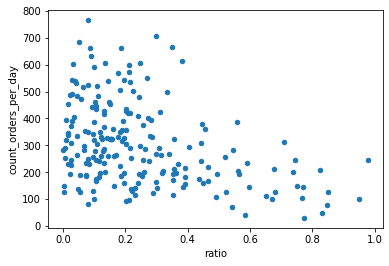

In [156]:
by_place[by_place.ratio<1][['ratio', 'count_orders_per_day']].plot.scatter(x='ratio', y='count_orders_per_day')

<AxesSubplot:xlabel='ratio', ylabel='lavka_exist_month'>

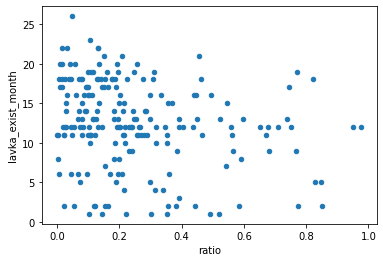

In [157]:
by_place[by_place.ratio<1][['ratio', 'lavka_exist_month']].plot.scatter(x='ratio', y='lavka_exist_month')

# Построим на карте

In [ ]:
import folium

In [242]:
geo = greenplum("""
Select distinct external_id_left as external_id, geometry_zone
from  analyst.iat_lavki_hex_hist
where month_order_left='2021-05-01'::date
""")

In [267]:
for_map = pd.merge(geo, by_place.reset_index(), on='external_id')

In [268]:
from shapely import wkt
import geopandas as gpd

In [269]:
for_map['geometry'] = for_map.geometry_zone.apply(lambda x: wkt.loads(x))

In [270]:
for_map = gpd.GeoDataFrame(for_map)

In [271]:
for_map = for_map[for_map.count_orders_per_day>0]

In [303]:
for_map.signed_ratio.quantile([0, 0.15, 0.27, 0.7, 1])

0.00   -0.955729
0.15   -0.040986
0.27    0.003109
0.70    0.209134
1.00    5.326674
Name: signed_ratio, dtype: float64

In [310]:
def create_map(result_table_for_geo):
    m = folium.Map(location=[55.777157, 37.436088], zoom_start=11)

    choropleth = folium.Choropleth(
        geo_data=result_table_for_geo.to_json(),
        name="choropleth",
        data=result_table_for_geo,
        columns=["external_id", "signed_ratio"],
        key_on="feature.properties.external_id",
        fill_color="YlGnBu",
        bins=for_map.signed_ratio.quantile([0, 0.15, 0.27, 0.7, 1]),
#         fill_opacity=0.7,
        line_opacity=0.2,
        show=True,


    )


    
    # Display Region Label
    choropleth.geojson.add_child( folium.features.GeoJsonTooltip(
        fields=['external_id', 'signed_ratio', 'count_orders_per_day'], 
        aliases=['ID Лавки', 'ошибка', 'Заказов в день']
    )
    )

    
    for key in choropleth._children:
        if key.startswith('color_map'):
            del(choropleth._children[key])

    choropleth.add_to(m)

#     folium.LayerControl().add_to(m)


    return m

In [311]:
create_map(for_map[for_map.ratio<2])

# Находим лучший полигон

In [158]:
test_for_best = test.copy()

In [237]:
test.cte_mean.mean()/test.cte_std.mean()

2.238936692294753

In [238]:
test_for_best['cte_mean'] = 15*60
test_for_best['cte_std'] = test_for_best['cte_mean']/(test.cte_mean.mean()/test.cte_std.mean())

In [308]:
X_test_for_best = test_for_best[features_core]
Y_test_for_best = test_for_best.count_orders


In [309]:
best_result = best_grid.predict(X_test_for_best)

In [313]:
test['predict_15min_cte']=best_result


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [314]:
test['predict_15min_cte'].isnull().sum()

0

In [316]:
test['best_predict'] = test.groupby(test['external_id'])['predict_15min_cte'].transform('max')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [317]:
test['best_predict'].isnull().sum()

0

In [318]:
test[test['predict_15min_cte'] == test['best_predict']][['external_id','hex_gid']].to_csv('best_hex_model_1306.csv')

In [321]:
test['h3_geometry']=test['hex_gid'].apply(lambda x: Point( h3.h3_to_geo(x)))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [324]:
import geo_functions as gf

In [326]:
gdf_may_hex = gf.get_gdf(test,'h3_geometry',4326)

In [327]:
test[test['predict_15min_cte'] == test['best_predict']][['external_id','hex_gid','h3_geometry']]

,month_order,external_id,hex_gid,lavka_exist_month,ttl_pop_res,A_res,B1_res,B2_res,C1_res,C2_res,...,Ресторан_hex,Спортбар_hex,Столовая_hex,Супермаркет_hex,Суши-бар_hex,Универмаг_hex,predict_orders,best_predict,predict_15min_cte,h3_geometry
0,2021-05-01,60287,8911aa785dbffff,26,564.51,0.93,16.74,110.67,361.77,72.54,...,0.0,0.0,0.0,0.0,0.0,0.0,632.373886,1264.363739,713.910351,POINT (55.71793 37.57407)
1,2021-05-01,60287,8911aa78427ffff,26,0.12,0.00,0.02,0.00,0.10,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.073216,1264.363739,2.235414,POINT (55.71476 37.58123)
2,2021-05-01,169093,8911aa78427ffff,12,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.307383,1434.565872,1.341013,POINT (55.71476 37.58123)
3,2021-05-01,60287,8911aa78437ffff,26,99.00,0.00,3.30,21.12,61.71,11.88,...,1.0,0.0,1.0,0.0,0.0,0.0,225.917105,1264.363739,221.358861,POINT (55.71506 37.57609)
4,2021-05-01,60287,8911aa78553ffff,26,0.01,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.579841,1264.363739,1.651410,POINT (55.71734 37.58435)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13753,2021-05-01,391733,8911aa7906bffff,1,4.80,0.00,0.80,0.80,2.40,0.80,...,1.0,0.0,1.0,0.0,0.0,0.0,11.363014,981.134287,11.627485,POINT (55.64068 37.62343)
13754,2021-05-01,391733,8911aa7906fffff,1,0.69,0.00,0.09,0.33,0.24,0.03,...,0.0,0.0,0.0,0.0,0.0,0.0,3.327337,981.134287,3.290746,POINT (55.64326 37.62655)
13755,2021-05-01,95108,8911aa6aa33ffff,18,1.00,0.00,0.00,0.50,0.50,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.472639,947.882402,1.551764,POINT (55.73383 37.86914)
13756,2021-05-01,95108,8911aa6aa27ffff,18,0.36,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.487680,947.882402,1.551764,POINT (55.73609 37.87744)


# Оценка нового CTE

#### Сюда нужно подсунуть нужный файлик и, возможно, поменять названия столбцов

In [369]:
# new_cte = pd.read_csv('./df_hex_cte_cov_model_best.csv', index_col=0)
new_cte = pd.read_csv('./df_hex_cte_best_withcoef.csv', index_col=0)

In [370]:
new_cte['external_id'] = new_cte['external_id'].astype(str)

In [386]:
new_cte.columns

Index(['external_id', 'hex_gid_best', 'hex_gid', 'count_orders', 'cte_mean',
       'coef_fact', 'hex_dist_fact', 'new_cte', 'hex_dist_model', 'coef',
       'new_cte_cov', 'hex_dist', 'coef_cov'],
      dtype='object')

In [338]:
# new_cte.drop('index', axis=1, inplace=True)
# new_cte.columns = ['hex_gid','external_id','cte_sec_coverage','count_orders','cte_fact_may', 'cte_sec_model']

In [387]:
new_cte_test = pd.merge(test.drop(['cte_mean','count_orders'],axis=1), new_cte.drop_duplicates(), on=['hex_gid', 'external_id'], how='inner')

In [340]:
# new_cte_test.groupby([ 'external_id'])['cte_sec_coverage','cte_mean', 'cte_sec_model'].mean()

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,cte_sec_coverage,cte_mean,cte_sec_model
external_id,,,
101892,924.500000,803.411690,853.125000
103127,1305.000000,1213.232554,1288.125000
103131,1203.225000,1098.954041,1117.500000
103143,1486.848837,1352.198326,1421.162791
103147,1677.029703,1549.369520,1664.623762
...,...,...,...
94832,1225.403226,1028.471918,1150.693548
94848,1148.911765,956.693121,1125.029412
94856,1260.263158,1189.693865,1165.263158


In [227]:
new_cte_test[['cte_sec_coverage','cte_mean', 'cte_sec_model','predict_cte_model','predict_cte_cov','predict_orders']].mean()

cte_sec_coverage     1366.661137
cte_mean             1294.134409
cte_sec_model        1333.158768
predict_cte_model     153.312395
predict_cte_cov       150.465182
predict_orders        158.012449
dtype: float64

In [365]:
features_core

['cte_std',
 '%_C12_res',
 'C2_work',
 '%_2544',
 'Кафе_6mbike',
 '%_female_work',
 'dist_lavka_by_samokat',
 'Магазин алкогольных напитков_6mbike',
 'lavka_exist_month',
 '%_4554',
 'C1_res',
 'cte_mean',
 'dist2lavki',
 'C2_res']

In [366]:
features_core_cov = ['cte_std',
 '%_C12_res',
 'C2_work',
 '%_2544',
 'Кафе_6mbike',
 '%_female_work',
 'dist_lavka_by_samokat',
 'Магазин алкогольных напитков_6mbike',
 'lavka_exist_month',
 '%_4554',
 'C1_res',
 'new_cte_cov',
 'dist2lavki',
 'C2_res']
features_core_model = ['cte_std',
 '%_C12_res',
 'C2_work',
 '%_2544',
 'Кафе_6mbike',
 '%_female_work',
 'dist_lavka_by_samokat',
 'Магазин алкогольных напитков_6mbike',
 'lavka_exist_month',
 '%_4554',
 'C1_res',
 'new_cte',
 'dist2lavki',
 'C2_res']

In [372]:
 new_cte_test.isnull().mean()

month_order          0.0
external_id          0.0
hex_gid              0.0
lavka_exist_month    0.0
ttl_pop_res          0.0
                    ... 
hex_dist_model       0.0
coef                 0.0
new_cte_cov          0.0
hex_dist             0.0
coef_cov             0.0
Length: 134, dtype: float64

In [388]:
X_cte_cov = new_cte_test[features_core_cov]
predict_cte_cov = best_grid.predict(X_cte_cov )
new_cte_test['predict_cte_cov'] = predict_cte_cov 


X_cte_model = new_cte_test[features_core_model]
predict_cte_model = best_grid.predict(X_cte_model )
new_cte_test['predict_cte_model'] = predict_cte_model

In [389]:
new_cte_test.columns.tolist()

['month_order',
 'external_id',
 'hex_gid',
 'lavka_exist_month',
 'ttl_pop_res',
 'A_res',
 'B1_res',
 'B2_res',
 'C1_res',
 'C2_res',
 '0_17_res',
 '18_24_res',
 '25_34_res',
 '35_44_res',
 '45_54_res',
 '55_99_res',
 'f_res',
 'm_res',
 '%_female_res',
 '%_C12_res',
 '%_2534',
 '%_3544',
 '%_2544',
 '%_4554',
 'ttl_pop_work',
 'A_work',
 'B1_work',
 'B2_work',
 'C1_work',
 'C2_work',
 '0_17_work',
 '18_24_work',
 '25_34_work',
 '35_44_work',
 '45_54_work',
 '55_99_work',
 'dist_lavka_by_samokat',
 'f_work',
 'm_work',
 '%_female_work',
 '%_C12_work',
 'ttl_pop',
 'flg_samokat_15m',
 'flg_lavka_15m',
 'cte_std',
 'dist2samokat',
 'dist2lavki',
 'Бар безалкогольных напитков_6mbike',
 'Бар, паб_6mbike',
 'Бизнес-центр_6mbike',
 'Булочная, пекарня_6mbike',
 'Быстрое питание_6mbike',
 'Гипермаркет_6mbike',
 'Диетические и диабетические продукты_6mbike',
 'Кальян-бар_6mbike',
 'Кафе_6mbike',
 'Кондитерская_6mbike',
 'Кофейня_6mbike',
 'Магазин алкогольных напитков_6mbike',
 'Магазин воды_

In [382]:
new_cte_test[['predict_cte_cov','predict_cte_model', 'predict_orders']].sum()

predict_cte_cov      1.967980e+06
predict_cte_model    1.992413e+06
predict_orders       1.993315e+06
dtype: float64

In [385]:
new_cte_test.columns

Index(['month_order', 'external_id', 'hex_gid', 'lavka_exist_month',
       'ttl_pop_res', 'A_res', 'B1_res', 'B2_res', 'C1_res', 'C2_res',
       ...
       'coef_fact', 'hex_dist_fact', 'new_cte', 'hex_dist_model', 'coef',
       'new_cte_cov', 'hex_dist', 'coef_cov', 'predict_cte_cov',
       'predict_cte_model'],
      dtype='object', length=135)

In [392]:
new_cte_test[['external_id', 'hex_gid_best', 'hex_gid', 'count_orders','predict_orders', 'cte_mean',
       'coef_fact', 'hex_dist_fact', 'new_cte', 'hex_dist_model', 'coef','predict_cte_model',
       'new_cte_cov', 'hex_dist', 'coef_cov','predict_cte_cov']]

,external_id,hex_gid_best,hex_gid,count_orders,predict_orders,cte_mean,coef_fact,hex_dist_fact,new_cte,hex_dist_model,coef,predict_cte_model,new_cte_cov,hex_dist,coef_cov,predict_cte_cov
0,60287,8911aa7a367ffff,8911aa785dbffff,849.0,632.373886,1088.076651,1.681848,3,1088.076651,3,1.681848,632.373886,1295.637530,5,2.002677,589.707499
1,60287,8911aa7a367ffff,8911aa78427ffff,0.0,1.073216,1191.704931,2.002677,5,1191.704931,5,2.002677,1.073216,1246.003566,6,2.093926,1.073216
2,169093,8911aa7819bffff,8911aa78427ffff,0.0,0.307383,1394.339879,2.255775,8,1355.131089,7,2.192342,0.307383,1570.025311,10,2.540000,0.307383
3,60287,8911aa7a367ffff,8911aa78437ffff,441.0,225.917105,1246.784580,1.884115,4,1246.784580,4,1.884115,225.917105,1385.624209,6,2.093926,196.442214
4,60287,8911aa7a367ffff,8911aa78553ffff,0.0,0.579841,1191.704931,2.002677,5,1191.704931,5,2.002677,0.579841,1191.704931,5,2.002677,0.579841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12535,190153,8911aa4dbd3ffff,8911aa4d327ffff,0.0,6.904145,1357.509342,2.255775,8,1805.378932,13,3.000000,6.813599,1805.378932,12,3.000000,6.813599
12536,190153,8911aa4dbd3ffff,8911aa4de43ffff,18.0,51.635432,1245.235294,2.093926,6,1655.218127,11,2.783333,47.443248,1510.510435,10,2.540000,49.144940
12537,95108,8911aa6aab7ffff,8911aa6aa33ffff,0.0,0.472639,991.727319,1.496919,2,1114.244969,3,1.681848,0.472639,1114.244969,3,1.681848,0.472639
12538,95108,8911aa6aab7ffff,8911aa6aa27ffff,0.0,0.487680,991.727319,1.681848,3,1110.996815,4,1.884115,0.487680,1110.996815,4,1.884115,0.487680


In [381]:
new_cte_test.groupby('external_id')[['predict_cte_cov','predict_cte_model', 'predict_orders']].sum()\
.join(
    new_cte_test.groupby('external_id')[['new_cte_cov','cte_mean', 'new_cte']].mean()
)

,predict_cte_cov,predict_cte_model,predict_orders,new_cte_cov,cte_mean,new_cte
external_id,,,,,,
101892,8121.520529,8334.058436,8427.137479,840.291459,803.411690,811.871814
103127,6822.990843,6861.102104,6828.624297,1247.831815,1213.232554,1228.603917
103131,11464.988598,12514.522252,12751.263293,1202.804297,1098.954041,1123.824354
103143,12803.579064,13509.473813,13509.473813,1480.648764,1352.198326,1352.198326
103147,17139.283449,16564.759790,17217.234264,1550.178039,1549.369520,1589.459372
...,...,...,...,...,...,...
94832,15046.342091,15874.303565,16038.709012,1129.547187,1028.471918,1052.443009
94848,6097.156822,6289.555752,6217.549900,1036.519595,956.693121,1008.232063
94856,10959.129599,12293.055474,12293.055474,1318.420872,1189.693865,1189.693865


In [394]:
new_cte_test['diff_orders_cov'].sum()

new_cte_test['diff_orders_model'].sum()

-25334.949847507

In [399]:
new_cte_test[['external_id', 'hex_gid_best', 'hex_gid', 'count_orders','predict_orders', 'cte_mean',
       'coef_fact', 'hex_dist_fact', 'new_cte', 'hex_dist_model', 'coef','predict_cte_model',
       'new_cte_cov', 'hex_dist', 'coef_cov','predict_cte_cov','diff_orders_cov','diff_orders_model']].to_csv('cte_info_full.csv')

In [231]:
new_cte_test.groupby('external_id')[['predict_cte_cov','predict_cte_model', 'predict_orders']].sum().to_csv('new_cte_predict_orders.csv')

In [393]:
new_cte_test['diff_orders_cov'] = new_cte_test.predict_cte_cov- new_cte_test.predict_orders
new_cte_test['diff_orders_model'] = new_cte_test.predict_cte_model - new_cte_test.predict_orders

In [ ]:
new_cte_test.groupby('external_id')['diff_orders_cov'].sum()

(array([ 8., 14., 22., 46., 70., 17., 14.,  1.,  0.,  1.]),
 array([-1333.92587515, -1024.94745384,  -715.96903253,  -406.99061122,
          -98.01218991,   210.9662314 ,   519.94465271,   828.92307402,
         1137.90149533,  1446.87991664,  1755.85833795]),
 <BarContainer object of 10 artists>)

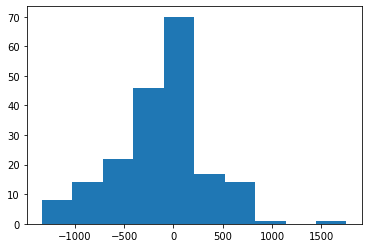

In [396]:
plt.hist(new_cte_test.groupby('external_id')['diff_orders_cov'].sum())

(array([  1.,   2.,   5.,  12.,  18., 108.,  24.,  14.,   8.,   1.]),
 array([-1187.20005453,  -978.79920509,  -770.39835564,  -561.9975062 ,
         -353.59665675,  -145.1958073 ,    63.20504214,   271.60589159,
          480.00674104,   688.40759048,   896.80843993]),
 <BarContainer object of 10 artists>)

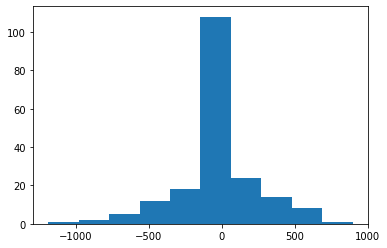

In [397]:
plt.hist(new_cte_test.groupby('external_id')['diff_orders_model'].sum())

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.1000e+01, 1.0800e+02, 1.2397e+04, 1.4100e+02]),
 array([-5813.58691938, -5134.29818586, -4455.00945234, -3775.72071883,
        -3096.43198531, -2417.1432518 , -1737.85451828, -1058.56578476,
         -379.27705125,   300.01168227,   979.30041578]),
 <BarContainer object of 10 artists>)

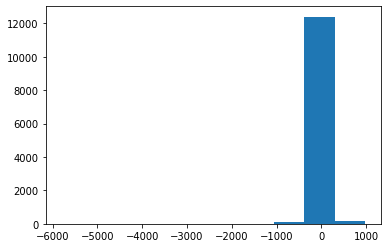

In [183]:
plt.hist(new_cte_test['diff_orders_model'])

In [516]:
new_cte_test['diff'].sum()/31

-5551.123548387097

In [519]:
new_cte_test[['month_order', 'external_id', 'hex_gid', 'count_orders', 'predict', 'diff']].to_csv('predict_best_locations.csv', sep='\t')